Spike-timing-dependent synaptic modification induced by natural spike trains  
Trying to apply this STDP rule   

Using all weak E cells, interconnected, and see what happens?


1. use the somewhat naive STDP rule (SONG-ABOTT)



1. with STDP dt has to be small. (defaultclock.dt = 0.01*ms)

In [2]:
from brian2 import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

SONG-ABBOTT STDP RULE

In [30]:
start_scope()

defaultclock.dt = 0.01*ms

Ne = 20

Cm = 1*ufarad/cm**2
El = -67*mV
ENa = 50*mV
EK = -100*mV
gl = 0.1*msiemens/cm**2
gNa = 100*msiemens/cm**2
gK = 80*msiemens/cm**2
V_I = -80*mV
V_E = 0*mV

# STDP vars
gmax = 1.0/Ne *msiemens/cm**2
gampa0 = 0.01/Ne *msiemens/cm**2

# gampa = 0.01*msiemens/cm**2
# ggaba = 0.6*msiemens/cm**2

# I = 1*amp*meter**-2
# I = np.random.uniform(0.2, 2,Ne)*amp*meter**-2

eqs = '''
dv/dt = ( (gl * (El-v) + gNa * m**3 * h * (ENa-v) + gK * n**4 * (EK-v) + Isyn + I))/Cm : volt
Isyn = Iampa : amp*meter**-2
Iampa = gampa * (V_E - v) * sampa_tot : amp*meter**-2
I : amp*meter**-2
sampa_tot : 1
gampa : siemens/meter**2
#Isyn = Igaba : amp*meter**-2
#Igaba = ggaba/Ni * (V_I - v) * sgaba_tot : amp*meter**-2
#sgaba_tot : 1
m = alpham / (alpham + betam) :1
dn/dt = alphan * (1-n) - betan * n : 1
dh/dt = alphah * (1-h) - betah * h : 1
alpham = (0.32/mV) * (v+54*mV) / (-exp((-v-54*mV) / (4*mV)) + 1)/ms : Hz
betam = (0.28/mV) * (v+27*mV)/ (exp((v+27*mV)/(5*mV)) - 1)/ms : Hz
alphah = (0.128) * exp(-(v+50*mV)/(18*mV))/ms : Hz
betah = 4/(exp((-v-27*mV) / (5*mV)) + 1)/ms : Hz
alphan = (0.032/mV) * (v+52*mV) / (-exp(-(v+52*mV) / (5*mV)) + 1)/ms : Hz
betan = 0.5*exp(-(v+57*mV)/(40*mV))/ms : Hz
'''

Ecells = NeuronGroup(Ne, eqs, threshold='v>0*mV',refractory='v > 0*mV',
                method='rk4')
Ecells.v = -60*mV
# STDP gampa start from small value
Ecells.gampa = gampa0
Ecells.I = np.random.uniform(0.2, 5,Ne)*amp*meter**-2
#Ecells.I = [0.1,1.0,(Ne-1)]*amp*meter**-2
Me = StateMonitor(Ecells, 'v', record=True)

# Synapses
tausampar = 0.2*ms
tausampad = 2*ms
kplus = gampa0/2
kminus = gampa0/3
gdelta = 1e-6/Ne *msiemens/cm**2
tau_plus = 10 *ms
tau_minus = 10*ms

eqs_ampa  = ''' 
sampa_tot_post = sampa : 1 (summed)
dsampa/dt= (1+tanh(v_pre/mV/10))/2 * (1-sampa)/tausampar - sampa/tausampad : 1 (clock-driven)
#w : 1 # synaptic weight
#dApre/dt = -Apre / taupre : 1 (event-driven)
#dApost/dt = -Apost / taupost : 1 (event-driven)
'''

# eqs_pre = '''
# gampa_temp : siemens/meter**2
# gampa_temp -= kminus*exp(t-lastspike_post)
# gampa = clip(gampa_temp, gdelta, gmax)
# '''

# eqs_post = '''
# gampa_temp : siemens/meter**2
# gampa_temp += kplus*exp(lastspike_pre-t)
# gampa = clip(gampa_temp, gdelta, gmax)
# '''

eqs_pre = '''
gampa = clip(gampa-kminus*exp((t-lastspike_post)/tau_minus), gdelta, gmax)
'''

eqs_post = '''
gampa = clip(gampa+kplus*exp((lastspike_pre-t)/tau_plus), gdelta, gmax)
'''

# try boolean
# eqs_pre = '''
# check1 = 1*(((t-lastspike_pre)/ms)<=1e-6) 
# gampa = clip(gampa-(check1*kminus*exp((t-lastspike_post)/tau_minus), gdelta, gmax)
# '''

# eqs_post = '''
# check1 = 1*(((t-lastspike_post)/ms)<=1e-6) 
# gampa = clip(gampa+(check2)*kplus*exp((lastspike_pre-t)/tau_plus), gdelta, gmax)
# '''

# # E to E, ampa
C_E_E = Synapses(Ecells, Ecells, model=eqs_ampa, 
                 on_pre = eqs_pre,
                 on_post = eqs_post,
                 method='rk4')
# # C_E_I = Synapses(Ecells, Icells, model=eqs_ampa, method='rk4')
C_E_E.connect(condition='i != j')
# C_E_I.w[:] = 1


mon = StateMonitor(C_E_E, 'gampa',record = True)
#mon = StateMonitor(C_E_E, 'sampa_tot',record = True)
#mon = StateMonitor(Ecells, 'v',record = True)

#sp_E = SpikeMonitor(Ecells,variables='v')
# sp_I = SpikeMonitor(Icells,variables='v')

In [31]:

run(1000*ms,report='stdout')


WARNING    "n" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value array([152.,  38.,  38.,  19.,  19.,   0.,  38.,  19.,   0.,  57.]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 2 lines of abstract code, first line is: "gampa = clip(gampa + (kplus * exp(_lio_1 * (_lio_2 + lastspike_pre))), gdelta, gmax)"
 [brian2.codegen.generators.base]


Starting simulation at t=0. s for a duration of 1. s
0.7207300000000001 (72%) simulated in 10s, estimated 4s remaining.
1.0 (100%) simulated in 13s


In [32]:
test_gampa =np.transpose(mon.gampa)

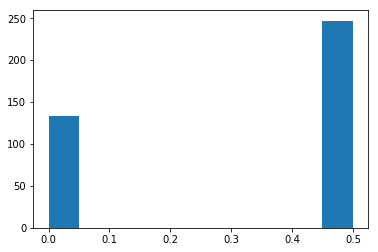

In [36]:
n, bins, patches = plt.hist(test_gampa[99999][:])
plt.show()

In [32]:
test1 = True
int(test1)

1

In [5]:
size(mon.gampa)

900

In [41]:
sp_E.v[1]

5.82707621 * mvolt

In [10]:
kplus

0.001 * siemens / meter ** 2

In [52]:
I = np.random.uniform(0.2, 2)*amp*meter**-2

In [53]:
I

0.58385509 * amp * meter ** -2

In [25]:
Ecells.dt

<neurongroup.dt: 100. * usecond>

In [84]:
C_E_E.gampa[1]

0.29838894 * siemens / meter ** 2

In [7]:
[0.1,1.0,(Ne-1)]*amp*meter**-2


array([0.1, 1. , 9. ]) * amp * meter ** -2

In [7]:
max(test_gampa[1999][:])

0.11390234 * siemens / meter ** 2

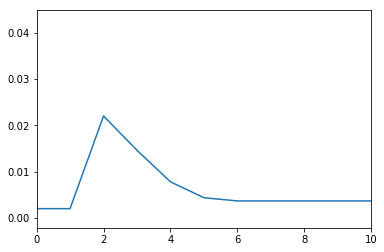

In [26]:
plt.plot(mon.gampa[9][:])
plt.xlim(0, 10)
#xmin, xmax = xlim() 
plt.show()

In [19]:
xmax

103.95

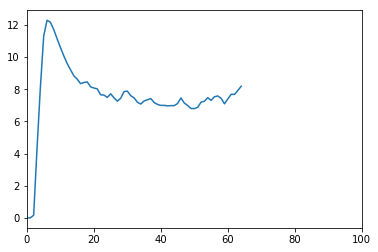

In [7]:
plt.plot(mon.sampa_tot[9][:])
plt.xlim(0, 100)
#xmin, xmax = xlim() 
plt.show()

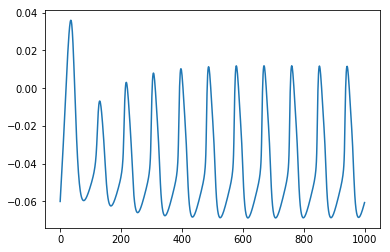

In [20]:
plot(mon.v[2][:])
plt.show()

In [15]:
Ecells.dt

<neurongroup_1.dt: 100. * usecond>

In [39]:
mon.gampa.shape

(380, 100000)